In [1]:
import os
import shutil
import random
import glob
import torch
import torchvision.datasets as datasets
import torch.nn as nn 
import torchvision.transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
os.chdir('Data')
os.getcwd()
# Data klasörünün içerisine klasörler oluşturuldu.
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

os.getcwd()
os.chdir('Cat')
os.getcwd()
for c in random.sample(glob.glob('Cat*'), 10000):
    shutil.move(c, '../train/cat')
for c in random.sample(glob.glob('Cat*'), 2000):
    shutil.move(c, '../valid/cat')
for c in random.sample(glob.glob('Cat*'), 500):
    shutil.move(c, '../test/cat')
os.getcwd()
os.chdir('../Dog')
os.getcwd()
for c in random.sample(glob.glob('Dog*'), 10000):
    shutil.move(c, '../train/dog')
for c in random.sample(glob.glob('Dog*'), 2000):
    shutil.move(c, '../valid/dog')
for c in random.sample(glob.glob('Dog*'), 500):
    shutil.move(c, '../test/dog')
os.getcwd()
os.chdir('../..')
os.getcwd()


Bu işlemlerden sonra Data klasörümüz içerisinde bulunan dizin yapısı şu şekilde olacaktır.

```
.
├── Cat
├── Dog
├── test (1000 adet)
│   ├── cat (500 adet)
│   └── dog (500 adet)
├── train (20000 adet)
│   ├── cat (10000 adet)
│   └── dog (10000 adet)
├── valid (4000 adet)
│   ├── cat (2000 adet)
│   └── dog (2000 adet)
└── renameFiles.sh
```

In [3]:
trainPath = 'Data/train'
validPath = 'Data/valid'
testPath = 'Data/test'

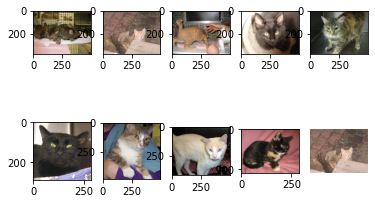

In [4]:
from PIL import Image
newtestPath = 'Data/test/cat/'
test_list = glob.glob(os.path.join(newtestPath, '*.jpg'))
random_idx = np.random.randint(1,64,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(test_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((255, 255)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize([0.5]*3, [0.5]*3)
                               ])
trainDataSet = datasets.ImageFolder(
    trainPath, transform=transform)

validDataSet = datasets.ImageFolder(
    validPath, transform=transform)

testDataSet = datasets.ImageFolder(
    testPath, transform=transform)

Bu işlemden sonra elimizde artık ImageFolder methodu sayesinde, her bir klasör içerisinde verilerin input'u ve label değerleri (x: Future y: Label) artık elimizde.

In [6]:
print('Eğitim veri seti boyutu: {}\nDoğrulama veri seti boyutu: {}\nTest veri seti boyutu {}'.format(len(trainDataSet),len(validDataSet),len(testDataSet)))

Eğitim veri seti boyutu: 19998
Doğrulama veri seti boyutu: 4000
Test veri seti boyutu 1000


Outputtan görüldüğü gibi 0 sonucu 'Cat' klasörü için indislenmiş. 1 sonucu ise 'Dog' klasörü için indislenmiş durumdadır.

In [7]:
print(testDataSet.classes)

['cat', 'dog']


In [8]:
loaders = {
    'train' : torch.utils.data.DataLoader(trainDataSet, 
                                          batch_size=64, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'validation'  : torch.utils.data.DataLoader(validDataSet, 
                                          batch_size=64, 
                                          shuffle=True, 
                                          num_workers=1),
                                          
    'test'  : torch.utils.data.DataLoader(testDataSet, 
                                          batch_size=64, 
                                          shuffle=True, 
                                          num_workers=1),
}

Aşağıda örnek bir görsel gösterilmiştir. Başlık olarak tensor tipinde resmin sınıfı verilmiştir. (0: Kedi, 1: Köpek)

Görsel gösterilirken Transpose işlemi uygulanmıştır. Plotlib (3, x, y) tipinde olan RGBA görüntüyü için tip tanımlaması (x, y, 3) olmalıdır.

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #RGB görüntü 3 kanallıdır.
                out_channels=16, #64 adet filtre oluşturmak istiyoruz
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, #RGB görüntü 3 kanallıdır.
                out_channels=32, #64 adet filtre oluşturmak istiyoruz
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fullyCon = nn.Sequential(
            nn.Linear(64 * 15 * 15, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.fullyCon(x)
        return output


In [ ]:
images , labels = next(iter(loaders['test']))
cnn = CNN()
output = cnn.conv1(images[0])
output = cnn.conv2(output)
output = cnn.conv3(output)
print(output.shape)

In [10]:
def trainAndValidation(cnn, loaders):
  epochs  = 10
  trainLossList = []
  validLossList = []
  optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001) 
  lossFunc = nn.CrossEntropyLoss()

  print("Begin training...") 
  for epoch in range(epochs):
    runningValidationLoss = 0.0 
    epoch_loss = 0
    epoch_accuracy = 0

    cnn.train() 
    for i, (images, labels) in enumerate(loaders['train']):
      images, labels = images.to(device), labels.to(device)
      output = cnn(images)
      loss = lossFunc(output, labels)
      optimizer.zero_grad() 
      loss.backward()    
      optimizer.step()
      acc = ((output.argmax(dim=1) == labels).float().mean())
      epoch_accuracy += acc/len(loaders['train'])
      epoch_loss += loss/len(loaders['train'])
      torch.cuda.empty_cache()
    trainLossList.append(epoch_loss)
    
    cnn.eval() 
    with torch.no_grad():
      epoch_val_accuracy=0
      epoch_val_loss =0
      for i, (data, labels) in enumerate(loaders['validation']):
        data, labels = data.to(device), labels.to(device)
        output = cnn(data)
        loss = lossFunc(output,labels)
        acc = ((output.argmax(dim=1) == labels).float().mean())
        epoch_val_accuracy += acc/ len(loaders['validation'])
        epoch_val_loss += loss/ len(loaders['validation'])
    validLossList.append(epoch_val_loss)


    print("Epoch: {} / {}, TrainLoss: {:.3f}, ValidationLoss: {:.3f}, train accuracy : {}".format(
        epoch+1, epochs, trainLossList[-1], validLossList[-1], epoch_accuracy))
      
  print("Finished training.") 

  return trainLossList, validLossList
    

In [11]:
cnn = CNN().to(device)
trainLossList, validLossList = trainAndValidation(cnn,loaders)

Begin training...
Epoch: 1 / 10, TrainLoss: 0.651, ValidationLoss: 0.582, train accuracy : 0.6072421073913574
Epoch: 2 / 10, TrainLoss: 0.569, ValidationLoss: 0.540, train accuracy : 0.7244077324867249
Epoch: 3 / 10, TrainLoss: 0.530, ValidationLoss: 0.526, train accuracy : 0.7699282765388489
Epoch: 4 / 10, TrainLoss: 0.507, ValidationLoss: 0.521, train accuracy : 0.793633759021759
Epoch: 5 / 10, TrainLoss: 0.487, ValidationLoss: 0.509, train accuracy : 0.8182812929153442
Epoch: 6 / 10, TrainLoss: 0.475, ValidationLoss: 0.506, train accuracy : 0.832122266292572
Epoch: 7 / 10, TrainLoss: 0.462, ValidationLoss: 0.506, train accuracy : 0.8471114635467529
Epoch: 8 / 10, TrainLoss: 0.453, ValidationLoss: 0.510, train accuracy : 0.8554847240447998
Epoch: 9 / 10, TrainLoss: 0.438, ValidationLoss: 0.501, train accuracy : 0.874081552028656
Epoch: 10 / 10, TrainLoss: 0.426, ValidationLoss: 0.502, train accuracy : 0.8847144246101379
Finished training.


In [28]:
cpuTrainLossList = []
cpuValidLossList = []
for i in trainLossList:
    a = i.cpu()
    a = a.detach().numpy()
    cpuTrainLossList.append(a)
for j in validLossList:
    b = j.cpu()
    b = b.detach().numpy()
    cpuValidLossList.append(b)

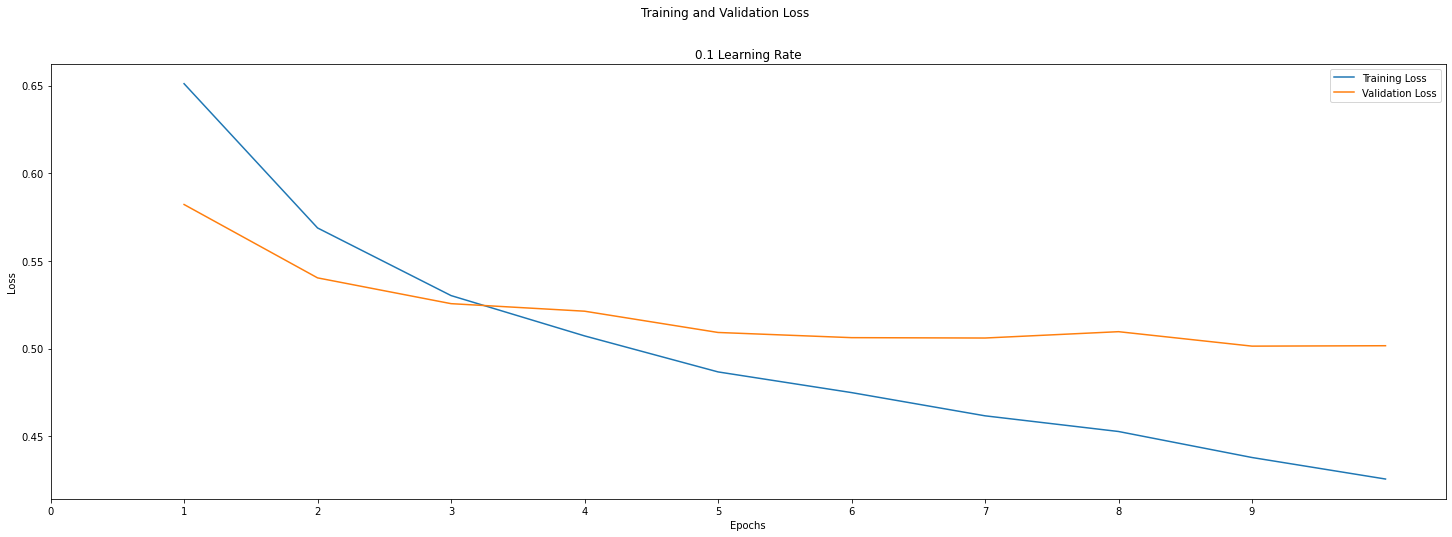

In [29]:
epochs = range(1,11)
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(25, 8)
fig.suptitle('Training and Validation Loss')
ax1.plot(epochs, cpuTrainLossList, label='Training Loss')
ax1.plot(epochs,cpuValidLossList, label='Validation Loss')
ax1.set_title('0.1 Learning Rate')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xticks(np.arange(0, 10, 1))
ax1.legend(loc='best')

In [34]:
torch.cuda.empty_cache()
predicList = []
labelList = []
labelCorrectList= []
cnn.eval() 
with torch.no_grad():
    for i, (data, labels) in enumerate(loaders['test']):
        data, labels = data.to(device), labels.to(device)
        labelList.append(labels)
        output = cnn(data)
        _, predicted = torch.max(output, 1)   
        predicList.append(predicted)
        label_correct_running = (predicted == labels).squeeze() 
        labelCorrectList.append(label_correct_running)

In [35]:
trueSize = 0
falseSize = 0
for i in labelCorrectList:
    for j in i:
        if j:
            trueSize += 1
        else:
            falseSize += 1
print("Doğruluk: ", trueSize/(trueSize+falseSize))


Doğruluk:  0.799


In [36]:
print(predicList[0])
print(labelList[0])
print(labelCorrectList[0])

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([ True, False,  True,  True, False,  True,  True,  True, False, False,
        False,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True], device='cuda:0')


Bu işlemde test verileri için ilk batch gösterilmiştir. Model eğitiminden sonra 80% doğruluk oranına erişilmiştir.

In [37]:
def saveModel():
    path = "./NeuralNetworkModel.pth"
    torch.save(cnn.state_dict(), path)


In [38]:
saveModel()